# < 멀티모달-영상 emotion labeling with GPT-4o >
**구축 목적**\
(1) Unseen data 사용으로 모델 성능 객관적 평가\
(2) 비(非)중의성 대 중의성 결과 비교로써 '중의성 해소' 성능 제시

**레이블링 대상**\
(1) Ambiguous 1000개 문장 감정 레이블링\
(2) Non-Ambiguous 1000개 문장 감정 레이블링

**구축 단계**\
(1) Build & Add Pre-Post 5 sentences: 비(非)중의성 데이터셋, 중의성 데이터셋 빌드 및 앞뒤 5문장 포함한 컬럼 추가\
(2) Sampling: 데이터셋 각각 랜덤 샘플링 1000개, 나머지 샘플 분리 및 파일명 기록 (재사용 가능성)\
(3) Labeling: GPT API 레이블링 요청 

# 1. Add pre-post 5 sentences

In [1]:
import os
import json
import pandas as pd

In [77]:
# 데이터 로드
# 발화 분리, 감정이 태깅된 자유대화(성인) inside
# file_path = '/content/drive/MyDrive/AIFFELthon/Data/Sample/대화별_발화분리_텍스트+감정_csv_(json에서_변환)/GPT_input/utterance_json_output_inside-GPT_input.csv'  # 업로드된 파일 경로
root_data_dir = '/aiffel/aiffel/AIFFELThon/data/input/LLM_labeling/'
general_pre_post_data = 'cond_1_(m=s=t)_PrePost5sentncs_Intent.csv'
ambiguous_pre_post_data = 'cond_2_(m=s!=t)_PrePost5sentncs_Intent.csv'

file_path = os.path.join(root_data_dir, general_pre_post_data)
general_pp = pd.read_csv(file_path)

file_path = os.path.join(root_data_dir, ambiguous_pre_post_data)
ambiguous_pp = pd.read_csv(file_path)

In [78]:
general_data_path = 'general_data.csv'
ambiguous_data_path = 'ambiguous_data.csv'

file_path = os.path.join(root_data_dir, general_data_path)
general = pd.read_csv(file_path, encoding='CP949')

file_path = os.path.join(root_data_dir, ambiguous_data_path)
ambiguous = pd.read_csv(file_path, encoding='CP949')

In [79]:
general_pp = general_pp[['file_index', 'pre_post_5_sentences']]
general_pp

,file_index,pre_post_5_sentences
0,0001-0400_1_9,"['야, 여기 있던 내 옷 못 봤어?', '무슨 옷 말하는 건데?', '그거, 내가..."
1,0001-0400_1_5,"['무슨 옷 말하는 건데?', '그거, 내가 생일에 친구한테 선물받은 원피스!', ..."
2,0001-0400_1_7,"['친구한테… 선물 받은 거?', '그래, 그 남색에, 어깨 부분에 장식 달린 거 ..."
3,0001-0400_1_3,"['그래, 그 남색에, 어깨 부분에 장식 달린 거 있잖아.', '아.. 그거… 그거..."
4,0001-0400_2_4,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
...,...,...
20602,5201-5600_5597_7,['그럼 어디로 가자고? 뭐 반지하 옥탑 이런데라도 갈래? 그게 니가 행...
20603,5201-5600_5599_15,"[' 뭐야? 웬 술?', '그냥. 아까 낮에 있었던 일.. 잘 풀고 싶어서.', '..."
20604,5201-5600_5599_10,"['….이해해.', '진짜로 이해해? 너 그런거 엄청 싫어했잖아.', '나도 행복해..."
20605,5201-5600_5600_8,"['근데 왜 나를 배신했어?', '뭐?', '왜 나를 두고 다른 여자랑 웃고, 떠들..."


In [80]:
df_general = general[['file_index', 'new_filename', 'person_id', 'script', 'm_s_t_emotion']].copy()
general_pp = general_pp['pre_post_5_sentences']
df_general = pd.concat([df_general, general_pp], axis=1, join='inner')
df_general

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences
0,0001-0400_1_9,clip1_5.wav,2,아.. 그거… 그거 내가 저번에 한 번 입었어.,fear,"['야, 여기 있던 내 옷 못 봤어?', '무슨 옷 말하는 건데?', '그거, 내가..."
1,0001-0400_1_5,clip1_6.wav,1,뭐? 그걸 니가 왜 입어?,angry,"['무슨 옷 말하는 건데?', '그거, 내가 생일에 친구한테 선물받은 원피스!', ..."
2,0001-0400_1_7,clip1_8.wav,1,야! 내 허락도 없이 니 맘대로 그걸 입으면 어떡해!,angry,"['친구한테… 선물 받은 거?', '그래, 그 남색에, 어깨 부분에 장식 달린 거 ..."
3,0001-0400_1_3,clip1_9.wav,2,"됐다, 됐어, 나도 이제 치사해서 안 입는다!",angry,"['그래, 그 남색에, 어깨 부분에 장식 달린 거 있잖아.', '아.. 그거… 그거..."
4,0001-0400_2_4,clip2_3.wav,2,너 아직도 정신 못 차렸구나.,contempt,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
...,...,...,...,...,...,...
20602,5201-5600_5597_7,clip5597_9.wav,279,그럼… 당신이랑 같이 못 살겠다.,dislike,['그럼 어디로 가자고? 뭐 반지하 옥탑 이런데라도 갈래? 그게 니가 행...
20603,5201-5600_5599_15,clip5599_0.wav,280,뭐야? 웬 술?,surprise,"[' 뭐야? 웬 술?', '그냥. 아까 낮에 있었던 일.. 잘 풀고 싶어서.', '..."
20604,5201-5600_5599_10,clip5599_8.wav,280,그게 무슨 말이야. 니 잘못 아니야. 누구의 잘못도 아니야.,surprise,"['….이해해.', '진짜로 이해해? 너 그런거 엄청 싫어했잖아.', '나도 행복해..."
20605,5201-5600_5600_8,clip5600_4.wav,279,"당신을 정말 사랑했어. 근데, 그래서 더 화가 나.",angry,"['근데 왜 나를 배신했어?', '뭐?', '왜 나를 두고 다른 여자랑 웃고, 떠들..."


In [81]:
ambiguous_pp = ambiguous_pp[['file_index', 'pre_post_5_sentences']]
ambiguous_pp

,file_index,pre_post_5_sentences
0,0001-0400_2_7,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
1,0001-0400_2_10,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
2,0001-0400_3_6,"['나 차 사려고.', '차를 산다고?', '응, 한대 뽑기로 했어.', '야, 니..."
3,0001-0400_3_5,"['응, 한대 뽑기로 했어.', '야, 니가 무슨 돈이 있어서 차를 사냐? 아빠가 ..."
4,0001-0400_3_12,"['야, 니가 무슨 돈이 있어서 차를 사냐? 아빠가 사주신대?', '응. 이번에 성..."
...,...,...
35860,5201-5600_5600_2,"['왜 나를 두고 다른 여자랑 웃고, 떠들고, 손을 잡고, 입을 맞추고,..."
35861,5201-5600_5600_10,"['당신을 정말 사랑했어. 근데, 그래서 더 화가 나.', ' 수지야. 너 왜그래...."
35862,5201-5600_5600_4,"[' 수지야. 너 왜그래.. ', '내가 가질 수 없는 건 싫어….', '..."
35863,5201-5600_5600_6,"['내가 가질 수 없는 건 싫어….', '뭐? 으아…. 왜 이렇게 아프지.', '..."


In [11]:
df_ambiguous = ambiguous[['file_index', 'new_filename', 'person_id', 'script', 'm_s_emotion', 'text_emotion']].copy()
ambiguous_pp = ambiguous_pp['pre_post_5_sentences']
df_ambiguous = pd.concat([df_ambiguous, ambiguous_pp], axis=1, join='inner')
df_ambiguous

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences
0,0001-0400_2_7,clip2_1.wav,2,오늘도 아니고 내일 지각한다는 게 뭔 소리야?,surprise,dislike,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
1,0001-0400_2_10,clip2_4.wav,1,정신 못차렸다니 그게 뭔 소리야.,neutral,dislike,"['새나야, 나 내일 지각할 거 같아. 니가 미리 자리 좀 맡아줘.', '오늘도 아..."
2,0001-0400_3_6,clip3_3.wav,2,"야, 니가 무슨 돈이 있어서 차를 사냐? 아빠가 사주신대?",surprise,contempt,"['나 차 사려고.', '차를 산다고?', '응, 한대 뽑기로 했어.', '야, 니..."
3,0001-0400_3_5,clip3_7.wav,2,내가 돈이 어딨냐? 덕분에 면허 딴 지 오 년 넘게 장롱면허 신세인데.,sad,dislike,"['응, 한대 뽑기로 했어.', '야, 니가 무슨 돈이 있어서 차를 사냐? 아빠가 ..."
4,0001-0400_3_12,clip3_8.wav,1,내가 차 사면 너 한 번 태워 줄게.,neutral,happy,"['야, 니가 무슨 돈이 있어서 차를 사냐? 아빠가 사주신대?', '응. 이번에 성..."
...,...,...,...,...,...,...,...
35860,5201-5600_5600_2,clip5600_7.wav,280,뭐? 으아…. 왜 이렇게 아프지.,surprise,fear,"['왜 나를 두고 다른 여자랑 웃고, 떠들고, 손을 잡고, 입을 맞추고,..."
35861,5201-5600_5600_10,clip5600_9.wav,280,수지야? 너 뭐 한거야….,surprise,fear,"['당신을 정말 사랑했어. 근데, 그래서 더 화가 나.', ' 수지야. 너 왜그래...."
35862,5201-5600_5600_4,clip5600_10.wav,279,미안해. 현아 씨한테는 내가 전할게.,dislike,sad,"[' 수지야. 너 왜그래.. ', '내가 가질 수 없는 건 싫어….', '..."
35863,5201-5600_5600_6,clip5600_11.wav,280,수지야… 살려줘…,fear,neutral,"['내가 가질 수 없는 건 싫어….', '뭐? 으아…. 왜 이렇게 아프지.', '..."


# 2. Sampling 


In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## [ver.1] 데이터셋 별로 중복 clip 없음 

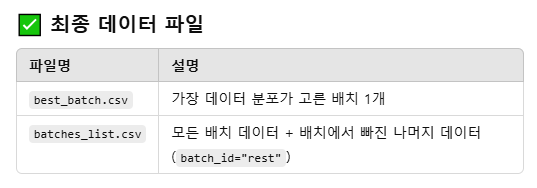

In [82]:
def split_df_with_unique_clips_per_batch(df, batch_size=1000):
    # 'clip{n}' 그룹을 추출하여 새로운 컬럼 추가
    df["clip_group"] = df["new_filename"].str.extract(r"(clip\d+)_")

    # clip_group별로 그룹화
    grouped = df.groupby("clip_group")

    # clip_id별 데이터 저장
    clip_groups = {clip_id: list(group.index) for clip_id, group in grouped}

    # clip_id 리스트 만들고 셔플
    clip_ids = list(clip_groups.keys())
    np.random.shuffle(clip_ids)

    # 결과 저장 리스트
    datasets = []
    used_files = set()  # 사용된 파일 추적

    pbar = tqdm(total=len(df), desc="Creating batches", unit="samples")

    while clip_ids:
        current_batch = []
        current_size = 0
        batch_clips = set()  # 현재 배치에서 사용된 clip_id 저장

        while clip_ids and current_size < batch_size:
            clip_id = clip_ids.pop(0)  # 랜덤하게 하나의 clip_id 선택

            # 현재 배치에서 clip_group 중복 방지
            if clip_id in batch_clips:
                continue  

            available_files = [idx for idx in clip_groups[clip_id] if idx not in used_files]

            if not available_files:
                continue  # 해당 clip_id의 파일이 모두 사용되었으면 스킵

            # 사용되지 않은 파일 중 하나 선택
            selected_idx = np.random.choice(available_files, 1)[0]
            used_files.add(selected_idx)

            # 데이터프레임에서 선택한 샘플 추가
            current_batch.append(df.loc[selected_idx])
            batch_clips.add(clip_id)
            current_size += 1
            pbar.update(1)

        if current_batch:
            datasets.append(pd.DataFrame(current_batch).reset_index(drop=True))

    pbar.close()  # 진행 바 닫기

    # ✅ 배치에 포함되지 않은 데이터 찾기
    all_used_files = set().union(*[set(batch.index) for batch in datasets])
    remaining_data = df.loc[~df.index.isin(all_used_files)].reset_index(drop=True)

    return datasets, remaining_data

In [22]:
# 중의성 데이터 샘플링 

batch_size=1000
df = df_ambiguous

# ✅ 실행 예제
batches, remaining_data = split_df_with_unique_clips_per_batch(df)

# ✅ 배치 개수 출력
print(f"총 {len(batches)}개의 배치가 생성됨 ✅")
print(f"배치로 포함되지 않은 데이터: {len(remaining_data)}개 ✅")

# ✅ 가장 데이터 분포가 고른 배치 선택 (clip_id 개수, person_id, emotion 기준)
best_batch = max(batches, key=lambda x: x["clip_group"].nunique())

# ✅ 결과 저장
best_batch.to_csv("best_batch.csv", index=False)  # 가장 균형 잡힌 배치 저장

# ✅ 나머지 배치 정보 CSV 저장 (각 행에 test01, test02 식으로 추가)
batch_list_df = pd.concat(batches, ignore_index=True)
batch_list_df["batch_id"] = np.repeat([f"test{str(i+1).zfill(2)}" for i in range(len(batches))], batch_size)[:len(batch_list_df)]

# ✅ 남은 데이터에 batch_id="rest" 추가
remaining_data["batch_id"] = "rest"

# ✅ 모든 데이터 합쳐서 저장
final_dataset = pd.concat([batch_list_df, remaining_data], ignore_index=True)
final_dataset.to_csv("batches_list.csv", index=False)

print(f"가장 데이터 분포가 고른 배치는 {best_batch.shape[0]}개의 샘플을 포함함 ✅")
print(f"전체 데이터가 빠짐없이 저장됨 ✅")

Creating batches:  16%|█▌        | 5567/35865 [00:01<00:06, 4915.38samples/s]


총 6개의 배치가 생성됨 ✅
배치로 포함되지 않은 데이터: 34865개 ✅
가장 데이터 분포가 고른 배치는 1000개의 샘플을 포함함 ✅
전체 데이터가 빠짐없이 저장됨 ✅


In [23]:
# best_batch.groupby(['clip_group', 'person_id']).count()
best_batch.groupby(['m_s_emotion', 'text_emotion']).count()

file_index  new_filename  person_id  script  \
m_s_emotion text_emotion                                                
angry       contempt               7             7          7       7   
            dislike               33            33         33      33   
            fear                  26            26         26      26   
            happy                  4             4          4       4   
            neutral               26            26         26      26   
            sad                   10            10         10      10   
            surprise               5             5          5       5   
contempt    angry                  2             2          2       2   
            dislike               12            12         12      12   
            fear                  10            10         10      10   
            happy                  1             1          1       1   
            neutral                5             5          5       5   
            sad                    3             3          3       3   
            surprise               1             1          1       1   
dislike     angry                 23            23         23      23   
            contempt              19            19         19      19   
            fear                  43            43         43      43   
            happy                 13            13         13      13   
            neutral               96            96         96      96   
            sad                   65            65         65      65   
            surprise               7             7          7       7   
fear        angry                  2             2          2       2   
            contempt               1             1          1       1   
            dislike                3             3          3       3   
            happy                  2             2          2       2   
            neutral               47            47         47      47   
            sad                   11            11         11      11   
            surprise               7             7          7       7   
happy       contempt               4             4          4       4   
            dislike                4             4          4       4   
            fear                  17            17         17      17   
            neutral              126           126        126     126   
            sad                   11            11         11      11   
            surprise              10            10         10      10   
neutral     contempt               1             1          1       1   
            dislike                5             5          5       5   
            fear                  14            14         14      14   
            happy                 32            32         32      32   
            sad                   11            11         11      11   
            surprise              15            15         15      15   
sad         angry                  3             3          3       3   
            contempt               2             2          2       2   
            dislike                6             6          6       6   
            fear                  20            20         20      20   
            happy                  4             4          4       4   
            neutral               49            49         49      49   
            surprise               6             6          6       6   
surprise    angry                  5             5          5       5   
            dislike                6             6          6       6   
            fear                  46            46         46      46   
            happy                 18            18         18      18   
            neutral               88            88         88      88   
            sad                   13            13         13      13   

          

In [30]:
best_batch.groupby('clip_group').count()

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences
clip_group,,,,,,,
clip1001,1,1,1,1,1,1,1
clip1005,1,1,1,1,1,1,1
clip101,1,1,1,1,1,1,1
clip1017,1,1,1,1,1,1,1
clip1018,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
clip979,1,1,1,1,1,1,1
clip98,1,1,1,1,1,1,1
clip981,1,1,1,1,1,1,1


In [31]:
best_batch

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
0,3201-3600_3359_6,clip3359_1.wav,167,저기요! 거기 남자! 어이!,angry,fear,"['저기요.', '저기요! 거기 남자! 어이!', '네? 저요?', '네 그쪽이요....",clip3359
1,3201-3600_3524_1,clip3524_1.wav,178,응 준영아. 엄마는 어디 가셨니?,surprise,happy,"['안녕하세요.', '응 준영아. 엄마는 어디 가셨니?', '네. 잠깐 장보러 가셨...",clip3524
2,3601-4000_3622_10,clip3622_9.wav,182,그 놈의 술이 문제야. 다들 그렇게 골골거리면서 왜 만나기만 하면 브레이크없이 달...,dislike,angry,"['어우 야. 건강검진에서 그렇게 나올 정도면 조심해야지.', '내 말이! 남편한테...",clip3622
3,4401-4800_4614_2,clip4614_11.wav,232,그래. 이름이 뭐니?,happy,neutral,[' 엄마가 아무나 따라가지 말라고 했는데. 그냥 길 알려주면 제가 혼자...,clip4614
4,0001-0400_103_10,clip103_5.wav,6,사람이 사람 좋아하는 건데 너무 이상하게 들만 생각 하는 것 같아. 나는 그런 사람...,neutral,happy,"['그럼 태용이 이제 검정고시 준비하는 건가?', '그러지 않을까? 휴. 마음이 ...",clip103
...,...,...,...,...,...,...,...,...
995,0801-1200_1106_5,clip1106_5.wav,56,한국대학교는 경영학과도 수학 잘해야 갈 수 있어요?,fear,neutral,"['반갑다. 나는 김정민이야.', '아… 네. 저는 오수민이예요.', '나는 한국대...",clip1106
996,2801-3200_3029_4,clip3029_2.wav,151,치킨?,happy,neutral,"[' 점심 뭐 먹지?', '글쎄에~', '치킨?', '그래. 무슨 치킨?', '튀긴...",clip3029
997,4001-4400_4329_10,clip4329_5.wav,218,근데 무슨 일인데? 뭐 심각한 일 있어?,angry,fear,"[' 아씨. 안되는데.', '왜? 뭐하는데?', ' 아.. 아니야.', '뭔데 그래...",clip4329
998,5201-5600_5599_13,clip5599_3.wav,279,….이해해.,dislike,neutral,"[' 뭐야? 웬 술?', '그냥. 아까 낮에 있었던 일.. 잘 풀고 싶어서.', '...",clip5599


In [35]:
final_dataset

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group,batch_id
0,3201-3600_3359_6,clip3359_1.wav,167,저기요! 거기 남자! 어이!,angry,fear,"['저기요.', '저기요! 거기 남자! 어이!', '네? 저요?', '네 그쪽이요....",clip3359,test01
1,3201-3600_3524_1,clip3524_1.wav,178,응 준영아. 엄마는 어디 가셨니?,surprise,happy,"['안녕하세요.', '응 준영아. 엄마는 어디 가셨니?', '네. 잠깐 장보러 가셨...",clip3524,test01
2,3601-4000_3622_10,clip3622_9.wav,182,그 놈의 술이 문제야. 다들 그렇게 골골거리면서 왜 만나기만 하면 브레이크없이 달...,dislike,angry,"['어우 야. 건강검진에서 그렇게 나올 정도면 조심해야지.', '내 말이! 남편한테...",clip3622,test01
3,4401-4800_4614_2,clip4614_11.wav,232,그래. 이름이 뭐니?,happy,neutral,[' 엄마가 아무나 따라가지 말라고 했는데. 그냥 길 알려주면 제가 혼자...,clip4614,test01
4,0001-0400_103_10,clip103_5.wav,6,사람이 사람 좋아하는 건데 너무 이상하게 들만 생각 하는 것 같아. 나는 그런 사람...,neutral,happy,"['그럼 태용이 이제 검정고시 준비하는 건가?', '그러지 않을까? 휴. 마음이 ...",clip103,test01
...,...,...,...,...,...,...,...,...,...
40427,5201-5600_5600_2,clip5600_7.wav,280,뭐? 으아…. 왜 이렇게 아프지.,surprise,fear,"['왜 나를 두고 다른 여자랑 웃고, 떠들고, 손을 잡고, 입을 맞추고,...",clip5600,rest
40428,5201-5600_5600_10,clip5600_9.wav,280,수지야? 너 뭐 한거야….,surprise,fear,"['당신을 정말 사랑했어. 근데, 그래서 더 화가 나.', ' 수지야. 너 왜그래....",clip5600,rest
40429,5201-5600_5600_4,clip5600_10.wav,279,미안해. 현아 씨한테는 내가 전할게.,dislike,sad,"[' 수지야. 너 왜그래.. ', '내가 가질 수 없는 건 싫어….', '...",clip5600,rest
40430,5201-5600_5600_6,clip5600_11.wav,280,수지야… 살려줘…,fear,neutral,"['내가 가질 수 없는 건 싫어….', '뭐? 으아…. 왜 이렇게 아프지.', '...",clip5600,rest


In [38]:
final_dataset.groupby(['batch_id']).count()

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
batch_id,,,,,,,,
rest,34865,34865,34865,34865,34865,34865,34865,34865
test01,1000,1000,1000,1000,1000,1000,1000,1000
test02,1000,1000,1000,1000,1000,1000,1000,1000
test03,1000,1000,1000,1000,1000,1000,1000,1000
test04,1000,1000,1000,1000,1000,1000,1000,1000
test05,1000,1000,1000,1000,1000,1000,1000,1000
test06,567,567,567,567,567,567,567,567


In [83]:
# 비(非)중의성 데이터 샘플링

batch_size=1000
df = df_general

# ✅ 실행 예제
batches, remaining_data = split_df_with_unique_clips_per_batch(df)

# ✅ 배치 개수 출력
print("비(非)중의성 데이터 샘플링")
print(f"총 {len(batches)}개의 배치가 생성됨 ✅")
print(f"배치로 포함되지 않은 데이터: {len(remaining_data)}개 ✅")

# ✅ 가장 데이터 분포가 고른 배치 선택 (clip_id 개수, person_id, emotion 기준)
best_batch_NonPragAmbig = max(batches, key=lambda x: x["clip_group"].nunique())

# ✅ 결과 저장
best_batch_NonPragAmbig.to_csv("best_batch_NonPragAmbig.csv", index=False)  # 가장 균형 잡힌 배치 저장

# ✅ 나머지 배치 정보 CSV 저장 (각 행에 test01, test02 식으로 추가)
batches_list_NonPragAmbig = pd.concat(batches, ignore_index=True)
batches_list_NonPragAmbig["batch_id"] = np.repeat([f"test{str(i+1).zfill(2)}" for i in range(len(batches))], batch_size)[:len(batches_list_NonPragAmbig)]

# ✅ 남은 데이터에 batch_id="rest" 추가
remaining_data["batch_id"] = "rest"

# ✅ 모든 데이터 합쳐서 저장
final_dataset = pd.concat([batches_list_NonPragAmbig, remaining_data], ignore_index=True)
final_dataset.to_csv("batches_list_NonPragAmbig.csv", index=False)

print(f"가장 데이터 분포가 고른 배치는 {best_batch_NonPragAmbig.shape[0]}개의 샘플을 포함함 ✅")
print(f"전체 데이터가 빠짐없이 저장됨 ✅")

Creating batches:  25%|██▌       | 5248/20607 [00:00<00:02, 5518.17samples/s]


비(非)중의성 데이터 샘플링
총 6개의 배치가 생성됨 ✅
배치로 포함되지 않은 데이터: 19607개 ✅
가장 데이터 분포가 고른 배치는 1000개의 샘플을 포함함 ✅
전체 데이터가 빠짐없이 저장됨 ✅


In [84]:
best_batch_NonPragAmbig.groupby('clip_group').count()

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences
clip_group,,,,,,
clip1000,1,1,1,1,1,1
clip1002,1,1,1,1,1,1
clip1006,1,1,1,1,1,1
clip1009,1,1,1,1,1,1
clip1014,1,1,1,1,1,1
...,...,...,...,...,...,...
clip975,1,1,1,1,1,1
clip980,1,1,1,1,1,1
clip993,1,1,1,1,1,1


In [85]:
final_dataset.groupby(['batch_id']).count()

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences,clip_group
batch_id,,,,,,,
rest,19607,19607,19607,19607,19607,19607,19607
test01,1000,1000,1000,1000,1000,1000,1000
test02,1000,1000,1000,1000,1000,1000,1000
test03,1000,1000,1000,1000,1000,1000,1000
test04,1000,1000,1000,1000,1000,1000,1000
test05,1000,1000,1000,1000,1000,1000,1000
test06,248,248,248,248,248,248,248


## [ver2.] 데이터셋(배치) 간 clip 중복 있음
**배치 내에서는 clip 중복 없음**

In [24]:
# def create_balanced_batches(df, batch_size=1000):
#     # clip_group 추출 (예: "clip2_4.wav" -> "clip2")
#     df["clip_group"] = df["new_filename"].str.extract(r"(clip\d+)_")

#     # clip_group 단위로 그룹화
#     grouped = df.groupby("clip_group")
    
#     # clip_group별 리스트 저장 (dict 대신 list 사용)
#     clip_data = [(clip_id, group) for clip_id, group in grouped]

#     # 결과 저장 리스트
#     batches = []
#     used_files = set()  # 사용된 발화 파일 추적

#     total_clips = len(clip_data)
#     pbar = tqdm(total=total_clips, desc="Creating batches", unit="clip_group")  # 진행 바 설정

#     while clip_data:
#         np.random.shuffle(clip_data)  # clip 순서를 랜덤하게 섞음

#         current_batch = []
#         current_size = 0
#         selected_clips = set()  # 현재 배치에서 사용된 clip 저장

#         new_clip_data = []  # 다음 루프에서 사용할 clip_data를 저장

#         for clip_id, clip_df in clip_data:
#             if clip_id in selected_clips:
#                 new_clip_data.append((clip_id, clip_df))  # 이미 배치에 들어간 clip은 다시 저장
#                 continue  

#             # 이미 사용된 발화 데이터 제외
#             clip_df = clip_df[~clip_df.index.isin(used_files)]

#             if clip_df.empty:
#                 continue  # 사용할 수 있는 데이터가 없으면 건너뜀

#             # batch_size를 초과하면 일부만 선택
#             if current_size + len(clip_df) > batch_size:
#                 clip_df = clip_df.sample(batch_size - current_size, random_state=42)

#             current_batch.append(clip_df)
#             selected_clips.add(clip_id)
#             used_files.update(clip_df.index)
#             current_size += len(clip_df)

#             if current_size >= batch_size:
#                 break  # batch_size를 만족하면 종료

#         if current_batch:
#             batches.append(pd.concat(current_batch, ignore_index=True))
#             pbar.update(len(selected_clips))  # 진행 바 업데이트

#         # 다음 루프에 사용할 clip_data 업데이트
#         clip_data = new_clip_data

#     pbar.close()  # 진행 바 닫기
#     return batches


In [25]:
# df = df_ambiguous

In [27]:
# # 실행 예제
# batch_size = 1000
# batches = create_balanced_batches(df, batch_size)

# # ✅ 가장 데이터 분포가 고른 배치 선택 (clip_id 개수, person_id, emotion 기준)
# best_batch = max(batches, key=lambda x: x["clip_group"].nunique())

# # ✅ 결과 저장
# best_batch.to_csv("best_batch.csv", index=False)  # 가장 균형 잡힌 배치 저장

# # ✅ 나머지 배치 정보 CSV 저장 (각 행에 test01, test02 식으로 추가)
# batch_list_df = pd.concat(batches, ignore_index=True)
# batch_list_df["batch_id"] = np.repeat([f"test{str(i+1).zfill(2)}" for i in range(len(batches))], batch_size)[:len(batch_list_df)]
# batch_list_df.to_csv("batches_list.csv", index=False)

# print(f"총 {len(batches)}개의 배치가 생성됨 ✅")
# print(f"가장 데이터 분포가 고른 배치는 {best_batch.shape[0]}개의 샘플을 포함함 ✅")

Creating batches:   3%|▎         | 163/5567 [00:00<00:02, 1910.81clip_group/s]

총 1개의 배치가 생성됨 ✅
가장 데이터 분포가 고른 배치는 1000개의 샘플을 포함함 ✅


# 2. GPT-4o-mini labeling

In [2]:
!pip install openai

     |████████████████████████████████| 460 kB 5.3 MB/s            
     |████████████████████████████████| 96 kB 8.2 MB/s             
     |████████████████████████████████| 431 kB 53.8 MB/s            
     |████████████████████████████████| 345 kB 67.8 MB/s            
     |████████████████████████████████| 73 kB 3.7 MB/s             
     |████████████████████████████████| 78 kB 10.3 MB/s            
     |████████████████████████████████| 58 kB 9.6 MB/s             
     |████████████████████████████████| 2.0 MB 57.3 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
  Attempting uninstall: h11
    Found existing installation: h11 0.9.0
    Uninstalling h11-0.9.0:
      Successfully uninstalled h11-0.9.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 0.9.1
    Uninstalling httpcore-0.9.1:
   

In [3]:
!pip show openai

Name: openai
Version: 1.61.0
Summary: The official Python library for the openai API
Home-page: 
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /opt/conda/lib/python3.9/site-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


In [5]:
!pip install --upgrade typing_extensions

In [1]:
import openai
from openai import OpenAI
import json
import os
import ast
import asyncio
import aiohttp
import pandas as pd
import re

In [2]:
# OpenAI API 키 설정
os.environ["OPENAI_API_KEY"] = "..."

In [3]:
# data above
best_batch = pd.read_csv('/aiffel/aiffel/AIFFELThon/best_batch.csv')
best_batch_NonPragAmbig = pd.read_csv('/aiffel/aiffel/AIFFELThon/best_batch_NonPragAmbig.csv')

In [4]:
best_batch.drop(columns='clip_group')

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences
0,3201-3600_3359_6,clip3359_1.wav,167,저기요! 거기 남자! 어이!,angry,fear,"['저기요.', '저기요! 거기 남자! 어이!', '네? 저요?', '네 그쪽이요...."
1,3201-3600_3524_1,clip3524_1.wav,178,응 준영아. 엄마는 어디 가셨니?,surprise,happy,"['안녕하세요.', '응 준영아. 엄마는 어디 가셨니?', '네. 잠깐 장보러 가셨..."
2,3601-4000_3622_10,clip3622_9.wav,182,그 놈의 술이 문제야. 다들 그렇게 골골거리면서 왜 만나기만 하면 브레이크없이 달...,dislike,angry,"['어우 야. 건강검진에서 그렇게 나올 정도면 조심해야지.', '내 말이! 남편한테..."
3,4401-4800_4614_2,clip4614_11.wav,232,그래. 이름이 뭐니?,happy,neutral,[' 엄마가 아무나 따라가지 말라고 했는데. 그냥 길 알려주면 제가 혼자...
4,0001-0400_103_10,clip103_5.wav,6,사람이 사람 좋아하는 건데 너무 이상하게 들만 생각 하는 것 같아. 나는 그런 사람...,neutral,happy,"['그럼 태용이 이제 검정고시 준비하는 건가?', '그러지 않을까? 휴. 마음이 ..."
...,...,...,...,...,...,...,...
995,0801-1200_1106_5,clip1106_5.wav,56,한국대학교는 경영학과도 수학 잘해야 갈 수 있어요?,fear,neutral,"['반갑다. 나는 김정민이야.', '아… 네. 저는 오수민이예요.', '나는 한국대..."
996,2801-3200_3029_4,clip3029_2.wav,151,치킨?,happy,neutral,"[' 점심 뭐 먹지?', '글쎄에~', '치킨?', '그래. 무슨 치킨?', '튀긴..."
997,4001-4400_4329_10,clip4329_5.wav,218,근데 무슨 일인데? 뭐 심각한 일 있어?,angry,fear,"[' 아씨. 안되는데.', '왜? 뭐하는데?', ' 아.. 아니야.', '뭔데 그래..."
998,5201-5600_5599_13,clip5599_3.wav,279,….이해해.,dislike,neutral,"[' 뭐야? 웬 술?', '그냥. 아까 낮에 있었던 일.. 잘 풀고 싶어서.', '..."


In [5]:
best_batch_NonPragAmbig.drop(columns='clip_group')

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences
0,3601-4000_3663_9,clip3663_4.wav,183,엄마가 좀 그렇긴 한데. 할머니 싸우지 마요. 엄마 맨날 울어.,sad,"['할머니, 왜 자꾸 엄마랑 싸워요?', ' 어른들끼리 할 얘기가 많아서 그래.',..."
1,2001-2400_2280_11,clip2280_4.wav,114,아빠… 너무 감동적이야.,happy,"[' 뭐야… 뭐 이런 걸 줘… 나 이제 이 집 사람도 아닌데, 아빠 써.', '무슨..."
2,3601-4000_3750_4,clip3750_1.wav,187,언니... 나 1년 동안 편하게 자 본 적이 없는 거 같애. 애 키우는 게 이렇게 ...,sad,"['요즘 잠은 잘 자니? 얼굴이 왜 이렇게 안 좋아.', '언니... 나 1년 동안..."
3,2001-2400_2053_12,clip2053_19.wav,103,저... 집에 갈래요... 무서워요...,fear,"['걔 나랑 같은 반이었어. 걔가 다닌 학원이 여기구나. 아, 재수없어.', '그 ..."
4,4001-4400_4335_3,clip4335_4.wav,217,이거 반응 보니까 맞네~ 맞네. 좋아하는 거 맞어~ 언제부터 좋아했어요...,happy,['프로필 보니까 엄청 예쁘던데.. 쌤 솔직히 그 여사친한테 마음 있죠...
...,...,...,...,...,...,...
995,4001-4400_4142_14,clip4142_2.wav,208,나는 경단이 좀 됐잖아.,sad,"['못 해서 안 하는 거면 가르쳐서라도 하겠는데, 그것도 아니에요. 자..."
996,1601-2000_1979_3,clip1979_13.wav,99,아빠 그냥 알려고 하지 마. 나 좀 내버려 둬.,dislike,"['그게 싫어? 사춘기는 누구나 겪는 건데. 너 하는 짓이 진짜 딱 사춘기같아.',..."
997,1201-1600_1370_7,clip1370_7.wav,70,쓰지!?화장실에?항상?두고?써.,neutral,['예전부터\xa0묻고\xa0싶었는데...\xa0바디\xa0샴푸\xa0쓰시냐구요.'...
998,3201-3600_3298_10,clip3298_4.wav,166,어머 너 작년에도 같은 반이었던 하나?,surprise,"['오늘 학교는 어땠어?', '오늘 엄마. 완전 대박이었어.', '왜?', '오늘 ..."


### 1) 맥락 정보 넣어주기 위한 가공
- script가 pre_post_5_sentences의 몇 번째인지 찾기
- 인코딩/디코딩 (코덱) 에러 문장 전처리

In [24]:
df_ambig = best_batch.copy()
df_non_ambig = best_batch_NonPragAmbig.copy()

In [25]:
df_ambig.head()

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
0,3201-3600_3359_6,clip3359_1.wav,167,저기요! 거기 남자! 어이!,angry,fear,"['저기요.', '저기요! 거기 남자! 어이!', '네? 저요?', '네 그쪽이요....",clip3359
1,3201-3600_3524_1,clip3524_1.wav,178,응 준영아. 엄마는 어디 가셨니?,surprise,happy,"['안녕하세요.', '응 준영아. 엄마는 어디 가셨니?', '네. 잠깐 장보러 가셨...",clip3524
2,3601-4000_3622_10,clip3622_9.wav,182,그 놈의 술이 문제야. 다들 그렇게 골골거리면서 왜 만나기만 하면 브레이크없이 달...,dislike,angry,"['어우 야. 건강검진에서 그렇게 나올 정도면 조심해야지.', '내 말이! 남편한테...",clip3622
3,4401-4800_4614_2,clip4614_11.wav,232,그래. 이름이 뭐니?,happy,neutral,[' 엄마가 아무나 따라가지 말라고 했는데. 그냥 길 알려주면 제가 혼자...,clip4614
4,0001-0400_103_10,clip103_5.wav,6,사람이 사람 좋아하는 건데 너무 이상하게 들만 생각 하는 것 같아. 나는 그런 사람...,neutral,happy,"['그럼 태용이 이제 검정고시 준비하는 건가?', '그러지 않을까? 휴. 마음이 ...",clip103


In [26]:
df_non_ambig.head()

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences,clip_group
0,3601-4000_3663_9,clip3663_4.wav,183,엄마가 좀 그렇긴 한데. 할머니 싸우지 마요. 엄마 맨날 울어.,sad,"['할머니, 왜 자꾸 엄마랑 싸워요?', ' 어른들끼리 할 얘기가 많아서 그래.',...",clip3663
1,2001-2400_2280_11,clip2280_4.wav,114,아빠… 너무 감동적이야.,happy,"[' 뭐야… 뭐 이런 걸 줘… 나 이제 이 집 사람도 아닌데, 아빠 써.', '무슨...",clip2280
2,3601-4000_3750_4,clip3750_1.wav,187,언니... 나 1년 동안 편하게 자 본 적이 없는 거 같애. 애 키우는 게 이렇게 ...,sad,"['요즘 잠은 잘 자니? 얼굴이 왜 이렇게 안 좋아.', '언니... 나 1년 동안...",clip3750
3,2001-2400_2053_12,clip2053_19.wav,103,저... 집에 갈래요... 무서워요...,fear,"['걔 나랑 같은 반이었어. 걔가 다닌 학원이 여기구나. 아, 재수없어.', '그 ...",clip2053
4,4001-4400_4335_3,clip4335_4.wav,217,이거 반응 보니까 맞네~ 맞네. 좋아하는 거 맞어~ 언제부터 좋아했어요...,happy,['프로필 보니까 엄청 예쁘던데.. 쌤 솔직히 그 여사친한테 마음 있죠...,clip4335


In [27]:
# 코덱 에러 예시 발화 문장
df_ambig[df_ambig['person_id']==46]

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
101,0801-1200_906_14,clip906_7.wav,46,정말??그럼?안?할래.,surprise,neutral,"['살만\xa0찌고..\xa0세상엔\xa0맛있는 게\xa0너무\xa0많아.', '그...",clip906
253,0801-1200_888_4,clip888_2.wav,46,음 난?치킨이?더?땡긴다.?치킨?시킬게.,happy,neutral,"['훈아\xa0피자\xa0먹을래?\xa0치킨\xa0먹을래?', '나는...\xa0피...",clip888
289,0801-1200_894_6,clip894_0.wav,46,훈아~?누나?술?마셨다.,happy,neutral,"['훈아~\xa0누나\xa0술\xa0마셨다.', '으\xa0술\xa0냄새.\xa0어...",clip894
524,0801-1200_913_10,clip913_4.wav,46,내가?황금?같은?시간에?시간내서?알려주고?있는데..!,dislike,neutral,"['이\xa0문제\xa0다\xa0풀면\xa0얘기해.', '아...\xa0이\xa0문...",clip913
701,0801-1200_904_5,clip904_12.wav,46,그래… 우리 둘 다 아직 너무 어린데. 이런 얘기하는게 좀 웃기긴 하다.,happy,neutral,['나도\xa0아직\xa0잘\xa0모르겠어..\xa0하..\xa0내가\xa0뭐가\x...,clip904
790,0801-1200_901_14,clip901_7.wav,46,너?무슨?일?생기면?꼭?나한테?말해야?된다.,surprise,neutral,"['이상하게\xa0오늘은\xa0먹고\xa0싶네.', '짠\xa0음식\xa0땡기는구나...",clip901
832,0801-1200_918_1,clip918_10.wav,46,뭐라고? 궁금해서 더 해보고 싶다고? 얘가 잔소리 못하게 하려고 이런 협박을 하네?,angry,fear,"['나?\xa0나\xa0담배\xa0피우냐고?\xa0아니야!', '너\xa0그\xa0...",clip918


In [28]:
# 코덱 에러 예시 발화 문장
df_ambig[df_ambig['person_id']==240]

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
122,4401-4800_4795_5,clip4795_1.wav,240,보자보자. 니 말대로 다른 사람하고 엘리베이터를 같이 탔네.,dislike,neutral,"[' 어! 네, 이 날이에요!\t 27일, 5시 16분!', '보자보자. 니 말대로...",clip4795
263,4401-4800_4787_9,clip4787_10.wav,240,근데?,dislike,neutral,"['아...아마 못갈 것 같아요.', '못 가도 x표시에 동그라미 치고 아 부모님 ...",clip4787
387,4401-4800_4786_13,clip4786_12.wav,240,어허…,dislike,neutral,"['아니. 그런거 아니에요. 그런게 아니라. \t저희 부모님 진짜 보수적이셔서, 제...",clip4786
552,4401-4800_4793_7,clip4793_3.wav,240,"아니, 아저씨가 그냥 궁금해서.\t 엄마 반지는 어쩌다 이리로 들고왔니?",dislike,neutral,"['무슨 건물에 제대로 된 CCTV 하나 없어요?', ' 근데, 너. \t 그런 반...",clip4793


In [29]:
# 리스트의 각 원소를 순회하면서 탭 문자(\t)와 비정상 공백(\xa0)만 제거하고,
# 리스트의 형식을 그대로 유지하는 정제 함수

def clean_list_column_keep_format(text):
    """
    리스트 형태의 문자열을 변환하고, 리스트 내 각 원소에서 
    탭 문자(\t) 및 비정상 공백(\xa0)만 제거 (리스트 형식 유지)
    """
    if isinstance(text, str):
        try:
            # 문자열이 리스트 형태라면 변환 (예: "['문장1', '문장2']" → ['문장1', '문장2'])
            text_list = ast.literal_eval(text)
            if not isinstance(text_list, list):
                return text  # 원본 문자열 그대로 반환
        except (ValueError, SyntaxError):
            return text  # 원본 문자열 그대로 반환
    elif isinstance(text, list):
        text_list = text
    else:
        return text  # 원본 그대로 반환

    # 리스트의 각 원소에서 탭(\t) 및 비정상 공백(\xa0) 제거 (리스트 형식 유지)
    cleaned_list = [s.replace("\t", " ").replace("\xa0", " ") if isinstance(s, str) else s for s in text_list]

    return str(cleaned_list)  # 리스트 형식을 유지하면서 문자열로 변환

# 'pre_post_5_sentences' 컬럼 정제 적용
df_ambig["pre_post_5_sentences"] = df_ambig["pre_post_5_sentences"].apply(clean_list_column_keep_format)
df_non_ambig["pre_post_5_sentences"] = df_non_ambig["pre_post_5_sentences"].apply(clean_list_column_keep_format)

In [30]:
def clean_text_v19(text):
    """ 
    'script' 컬럼의 특수문자 정리,
    '?'가 단어 사이에 있을 경우만 띄어쓰기로 변환,
    문장 끝이나 강조를 위한 '?'는 유지,
    '!', '~', ',' 및 '.'(1~3개 이하)을 원본 그대로 유지,
    '\t' (탭 문자)는 공백으로 변환.
    """
    if not isinstance(text, str):
        return ""

    # 단어 사이에 있는 '?'가 잘못 들어간 경우 공백으로 변환 (예: "훈아~?누나" → "훈아~ 누나")
    text = re.sub(r"\?(?=[가-힣a-zA-Z0-9])", " ", text)

    # '\t' (탭 문자)를 공백으로 변환
    text = text.replace("\t", " ")

    # \xa0 (비정상 공백) 제거
    text = text.replace("\xa0", " ")

    # 불필요한 공백 제거
    text = re.sub(r"\s+", " ", text).strip()

    return text

# 정제된 'script' 컬럼 적용
df_ambig["script"] = df_ambig["script"].apply(clean_text_v19)
df_non_ambig["script"] = df_non_ambig["script"].apply(clean_text_v19)

In [43]:
df_ambig = df_ambig.drop(columns=['clip_group','file_index','pre_post_5_sentences'])
df_non_ambig = df_non_ambig.drop(columns=['clip_group','file_index','pre_post_5_sentences'])

In [44]:
df_ambig.to_csv('/aiffel/aiffel/AIFFELThon/data/test_ambiguous.csv', index=False)
df_non_ambig.to_csv('/aiffel/aiffel/AIFFELThon/data/test_non_ambiguous.csv', index=False)

In [66]:
df_ambig

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
0,3201-3600_3359_6,clip3359_1.wav,167,저기요! 거기 남자! 어이!,angry,fear,"['저기요.', '저기요! 거기 남자! 어이!', '네? 저요?', '네 그쪽이요....",clip3359
1,3201-3600_3524_1,clip3524_1.wav,178,응 준영아. 엄마는 어디 가셨니?,surprise,happy,"['안녕하세요.', '응 준영아. 엄마는 어디 가셨니?', '네. 잠깐 장보러 가셨...",clip3524
2,3601-4000_3622_10,clip3622_9.wav,182,그 놈의 술이 문제야. 다들 그렇게 골골거리면서 왜 만나기만 하면 브레이크없이 달...,dislike,angry,"['어우 야. 건강검진에서 그렇게 나올 정도면 조심해야지.', '내 말이! 남편한테...",clip3622
3,4401-4800_4614_2,clip4614_11.wav,232,그래. 이름이 뭐니?,happy,neutral,[' 엄마가 아무나 따라가지 말라고 했는데. 그냥 길 알려주면 제가 혼자...,clip4614
4,0001-0400_103_10,clip103_5.wav,6,사람이 사람 좋아하는 건데 너무 이상하게 들만 생각 하는 것 같아. 나는 그런 사람...,neutral,happy,"['그럼 태용이 이제 검정고시 준비하는 건가?', '그러지 않을까? 휴. 마음이 ...",clip103
...,...,...,...,...,...,...,...,...
995,0801-1200_1106_5,clip1106_5.wav,56,한국대학교는 경영학과도 수학 잘해야 갈 수 있어요?,fear,neutral,"['반갑다. 나는 김정민이야.', '아… 네. 저는 오수민이예요.', '나는 한국대...",clip1106
996,2801-3200_3029_4,clip3029_2.wav,151,치킨?,happy,neutral,"[' 점심 뭐 먹지?', '글쎄에~', '치킨?', '그래. 무슨 치킨?', '튀긴...",clip3029
997,4001-4400_4329_10,clip4329_5.wav,218,근데 무슨 일인데? 뭐 심각한 일 있어?,angry,fear,"[' 아씨. 안되는데.', '왜? 뭐하는데?', ' 아.. 아니야.', '뭔데 그래...",clip4329
998,5201-5600_5599_13,clip5599_3.wav,279,….이해해.,dislike,neutral,"[' 뭐야? 웬 술?', '그냥. 아까 낮에 있었던 일.. 잘 풀고 싶어서.', '...",clip5599


In [69]:
# 코덱 에러 예시 발화 문장
df_ambig[df_ambig['person_id']==46]

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
101,0801-1200_906_14,clip906_7.wav,46,정말? 그럼 안 할래.,surprise,neutral,"['살만 찌고.. 세상엔 맛있는 게 너무 많아.', '그걸 다 먹을 수 없다는 게 ...",clip906
253,0801-1200_888_4,clip888_2.wav,46,음 난 치킨이 더 땡긴다. 치킨 시킬게.,happy,neutral,"['훈아 피자 먹을래? 치킨 먹을래?', '나는... 피자!', '음 난 치킨이 더...",clip888
289,0801-1200_894_6,clip894_0.wav,46,훈아~ 누나 술 마셨다.,happy,neutral,"['훈아~ 누나 술 마셨다.', '으 술 냄새. 어디서 이렇게 마셨어.', '오늘 ...",clip894
524,0801-1200_913_10,clip913_4.wav,46,내가 황금 같은 시간에 시간내서 알려주고 있는데..!,dislike,neutral,"['이 문제 다 풀면 얘기해.', '아... 이 문제 저번에 풀었는데...', '풀...",clip913
701,0801-1200_904_5,clip904_12.wav,46,그래… 우리 둘 다 아직 너무 어린데. 이런 얘기하는게 좀 웃기긴 하다.,happy,neutral,"['나도 아직 잘 모르겠어.. 하.. 내가 뭐가 될까.', '걱정이다, 걱정이야.'...",clip904
790,0801-1200_901_14,clip901_7.wav,46,너 무슨 일 생기면 꼭 나한테 말해야 된다.,surprise,neutral,"['이상하게 오늘은 먹고 싶네.', '짠 음식 땡기는구나.', '응 맵고 짠거. 스...",clip901
832,0801-1200_918_1,clip918_10.wav,46,뭐라고? 궁금해서 더 해보고 싶다고? 얘가 잔소리 못하게 하려고 이런 협박을 하네?,angry,fear,"['나? 나 담배 피우냐고? 아니야!', '너 그 나이부터 담배 배우면 폐가 썩는다...",clip918


In [70]:
# 코덱 에러 예시 발화 문장
df_ambig[df_ambig['person_id']==240]

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
122,4401-4800_4795_5,clip4795_1.wav,240,보자보자. 니 말대로 다른 사람하고 엘리베이터를 같이 탔네.,dislike,neutral,"[' 어! 네, 이 날이에요! 27일, 5시 16분!', '보자보자. 니 말대로 ...",clip4795
263,4401-4800_4787_9,clip4787_10.wav,240,근데?,dislike,neutral,"['아...아마 못갈 것 같아요.', '못 가도 x표시에 동그라미 치고 아 부모님 ...",clip4787
387,4401-4800_4786_13,clip4786_12.wav,240,어허…,dislike,neutral,"['아니. 그런거 아니에요. 그런게 아니라. 저희 부모님 진짜 보수적이셔서, 제가...",clip4786
552,4401-4800_4793_7,clip4793_3.wav,240,"아니, 아저씨가 그냥 궁금해서. 엄마 반지는 어쩌다 이리로 들고왔니?",dislike,neutral,"['무슨 건물에 제대로 된 CCTV 하나 없어요?', ' 근데, 너. 그런 반지...",clip4793


In [23]:
df_non_ambig

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences,clip_group
0,3601-4000_3663_9,clip3663_4.wav,183,엄마가 좀 그렇긴 한데. 할머니 싸우지 마요. 엄마 맨날 울어.,sad,"['할머니, 왜 자꾸 엄마랑 싸워요?', ' 어른들끼리 할 얘기가 많아서 그래.',...",clip3663
1,2001-2400_2280_11,clip2280_4.wav,114,아빠… 너무 감동적이야.,happy,"[' 뭐야… 뭐 이런 걸 줘… 나 이제 이 집 사람도 아닌데, 아빠 써.', '무슨...",clip2280
2,3601-4000_3750_4,clip3750_1.wav,187,언니... 나 1년 동안 편하게 자 본 적이 없는 거 같애. 애 키우는 게 이렇게 ...,sad,"['요즘 잠은 잘 자니? 얼굴이 왜 이렇게 안 좋아.', '언니... 나 1년 동안...",clip3750
3,2001-2400_2053_12,clip2053_19.wav,103,저... 집에 갈래요... 무서워요...,fear,"['걔 나랑 같은 반이었어. 걔가 다닌 학원이 여기구나. 아, 재수없어.', '그 ...",clip2053
4,4001-4400_4335_3,clip4335_4.wav,217,이거 반응 보니까 맞네~ 맞네. 좋아하는 거 맞어~ 언제부터 좋아했어요? 오래 됐어...,happy,['프로필 보니까 엄청 예쁘던데.. 쌤 솔직히 그 여사친한테 마음 있죠...,clip4335
...,...,...,...,...,...,...,...
995,4001-4400_4142_14,clip4142_2.wav,208,나는 경단이 좀 됐잖아.,sad,"['못 해서 안 하는 거면 가르쳐서라도 하겠는데, 그것도 아니에요. 자...",clip4142
996,1601-2000_1979_3,clip1979_13.wav,99,아빠 그냥 알려고 하지 마. 나 좀 내버려 둬.,dislike,"['그게 싫어? 사춘기는 누구나 겪는 건데. 너 하는 짓이 진짜 딱 사춘기같아.',...",clip1979
997,1201-1600_1370_7,clip1370_7.wav,70,쓰지! 화장실에 항상 두고 써.,neutral,"['예전부터 묻고 싶었는데... 바디 샴푸 쓰시냐구요.', '뭐... 집에 어디 있...",clip1370
998,3201-3600_3298_10,clip3298_4.wav,166,어머 너 작년에도 같은 반이었던 하나?,surprise,"['오늘 학교는 어땠어?', '오늘 엄마. 완전 대박이었어.', '왜?', '오늘 ...",clip3298


### 2) GPT 레이블링
- GPT API 요청을 위한 데이터 구성

In [9]:
import os
import json
import ast
import time
from openai import OpenAI  # OpenAI 라이브러리 사용

# OpenAI API Key 설정
API_KEY = os.getenv("OPENAI_API_KEY")

# GPT API 호출 함수
def create_chat_completion(sentence, context, system_input, model="gpt-4o-mini", temperature=1.15, max_tokens=150):
    try:
        user_input = f"""
        문장: "{sentence}"
        문맥: "{context}"
        위 문장을 분석하고 아래 JSON 스키마에 맞춰 결과를 출력해줘:
        ```json
        {{
          "name": "emotion_analysis",
          "strict": true,
          "schema": {{
            "type": "object",
            "required": [
              "primary_emotion",
              "secondary_emotion"
            ],
            "properties": {{
              "primary_emotion": {{
                "enum": [
                  "기쁨",
                  "슬픔",
                  "분노",
                  "놀람",
                  "공포",
                  "경멸",
                  "혐오"
                ],
                "type": "string",
                "description": "감정 분류 체계에 따라 선택된 가장 가능성 높은 감정."
              }},
              "secondary_emotion": {{
                "enum": [
                  "기쁨",
                  "슬픔",
                  "분노",
                  "놀람",
                  "공포",
                  "경멸",
                  "혐오"
                ],
                "type": "string",
                "description": "감정 분류 체계에 따라 선택된 두번째로 가능성 높은 감정."
              }}
            }},
            "additionalProperties": false
          }}
        }}
        ```
        """

        # 메시지 목록 생성
        messages = [
            {"role": "system", "content": system_input},
            {"role": "user", "content": user_input}
        ]

        # GPT API 호출
        response = OpenAI().chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )

        # 응답 처리
        content = response.choices[0].message.content
        clean_content = content.strip("```json").strip("```").strip()
        return json.loads(clean_content)  # JSON 변환 후 반환

    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
        return {"error": "Invalid JSON format"}
    except Exception as e:
        print(f"Error: {str(e)}")
        return {"error": str(e)}

# 시스템 프롬프트
system_input = """
Task: 너는 문장을 보고 문맥에 따라 감정 정보를 태깅하는 annotator야. 감정 레이블은 '기쁨,슬픔,분노,놀람,공포,경멸,혐오'로 이루어져 있어. 이 중에서 가장 타당한 1순위, 2순위 감정을 레이블링 해줘.
Calibration: 모호한 문장은 최대한 맥락을 반영하여 레이블링 해줘.
"""


In [25]:
# 결과 저장 리스트
results = []

df = df_ambig
# 데이터프레임(df)에서 문장별 감정 분석 수행
for i, row in df.iterrows():
    print(f"Processing sentence {i + 1}/{len(df)}")

    try:
        # 문맥 정보 추가
        sentences = ast.literal_eval(row["pre_post_5_sentences"])
        script = row["script"]
        position = sentences.index(script) if script in sentences else -1

        previous_sentences = " ".join(sentences[:position])
        next_sentences = " ".join(sentences[position+1:]) if position != -1 else ""
        context = f"{previous_sentences} {script} {next_sentences}".strip()

        # 감정 레이블링 수행
        result = create_chat_completion(script, context, system_input)

        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": result  # 감정 레이블링 결과
        })

    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e} for sentence: {script}")
        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": {"error": f"JSON Decode Error: {e}"}
        })
    except Exception as e:
        print(f"Error: {e} for sentence: {script}")
        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": {"error": str(e)}
        })

    # **Rate Limit 초과 방지를 위한 대기 시간 추가**
    time.sleep(1)  # 1초 대기 후 다음 요청

    # **50문장마다 중간 저장 (데이터 손실 방지)**
    if (i + 1) % 50 == 0:
        temp_output_file = f"/aiffel/aiffel/AIFFELThon/data/output/temp_emotion_analysis_{i + 1}.json"
        with open(temp_output_file, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)
        print(f"Temporary results saved to {temp_output_file}")



Processing sentence 1/1000
Processing sentence 2/1000
Processing sentence 3/1000
Processing sentence 4/1000
Processing sentence 5/1000
Processing sentence 6/1000
Processing sentence 7/1000
Processing sentence 8/1000
Processing sentence 9/1000
Processing sentence 10/1000
Processing sentence 11/1000
Processing sentence 12/1000
Processing sentence 13/1000
Processing sentence 14/1000
Processing sentence 15/1000
Processing sentence 16/1000
Processing sentence 17/1000
Processing sentence 18/1000
Processing sentence 19/1000
Processing sentence 20/1000
Processing sentence 21/1000
Processing sentence 22/1000
Processing sentence 23/1000
Processing sentence 24/1000
Processing sentence 25/1000
Processing sentence 26/1000
Processing sentence 27/1000
Processing sentence 28/1000
Processing sentence 29/1000
Processing sentence 30/1000
Processing sentence 31/1000
Processing sentence 32/1000
Processing sentence 33/1000
Processing sentence 34/1000
Processing sentence 35/1000
Processing sentence 36/1000
P

In [27]:
# **최종 결과를 JSON 파일로 저장**
output_file = "/aiffel/aiffel/AIFFELThon/data/output/emotion_analysis_sentences.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"Results saved to {output_file}")

Results saved to /aiffel/aiffel/AIFFELThon/data/output/emotion_analysis_sentences.json


In [ ]:
# 결과 저장 리스트
results = []

df = df_non_ambig
# 데이터프레임(df)에서 문장별 감정 분석 수행
for i, row in df.iterrows():
    print(f"Processing sentence {i + 1}/{len(df)}")

    try:
        # 문맥 정보 추가
        sentences = ast.literal_eval(row["pre_post_5_sentences"])
        script = row["script"]
        position = sentences.index(script) if script in sentences else -1

        previous_sentences = " ".join(sentences[:position])
        next_sentences = " ".join(sentences[position+1:]) if position != -1 else ""
        context = f"{previous_sentences} {script} {next_sentences}".strip()

        # 감정 레이블링 수행
        result = create_chat_completion(script, context, system_input)

        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": result  # 감정 레이블링 결과
        })

    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e} for sentence: {script}")
        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": {"error": f"JSON Decode Error: {e}"}
        })
    except Exception as e:
        print(f"Error: {e} for sentence: {script}")
        results.append({
            "sentence_id": i + 1,
            "sentence": script,
            "context": context,
            "result": {"error": str(e)}
        })

    # **Rate Limit 초과 방지를 위한 대기 시간 추가**
    time.sleep(1)  # 1초 대기 후 다음 요청

    # **50문장마다 중간 저장 (데이터 손실 방지)**
    if (i + 1) % 50 == 0:
        temp_output_file = f"/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_temp_emotion_analysis_{i + 1}.json"
        with open(temp_output_file, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)
        print(f"Temporary results saved to {temp_output_file}")

# **최종 결과를 JSON 파일로 저장**
output_file = "/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_emotion_analysis_sentences.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"Results saved to {output_file}")

Processing sentence 1/1000
Processing sentence 2/1000
Processing sentence 3/1000
Processing sentence 4/1000
Processing sentence 5/1000
Processing sentence 6/1000
Processing sentence 7/1000
Processing sentence 8/1000
Processing sentence 9/1000
Processing sentence 10/1000
Processing sentence 11/1000
Processing sentence 12/1000
Processing sentence 13/1000
Processing sentence 14/1000
Processing sentence 15/1000
Processing sentence 16/1000
Processing sentence 17/1000
Processing sentence 18/1000
Processing sentence 19/1000
Processing sentence 20/1000
Processing sentence 21/1000
Processing sentence 22/1000
Processing sentence 23/1000
Processing sentence 24/1000
Processing sentence 25/1000
Processing sentence 26/1000
Processing sentence 27/1000
Processing sentence 28/1000
Processing sentence 29/1000
Processing sentence 30/1000
Processing sentence 31/1000
Processing sentence 32/1000
Processing sentence 33/1000
Processing sentence 34/1000
Processing sentence 35/1000
Processing sentence 36/1000
P

In [14]:
# # 기존에 저장된 결과 파일 읽기
# results = []
# processed_ids = set()  # 처리된 문장의 ID를 저장

# output_file = "/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_temp_emotion_analysis_950.json"

# if os.path.exists(output_file):
#     with open(output_file, "r", encoding="utf-8") as f:
#         results = json.load(f)
#         processed_ids = {item["sentence_id"] for item in results}  # 이미 처리된 문장의 ID

# print(f"Loaded {len(processed_ids)} sentences from previous results.")


# df = df_non_ambig
# # 데이터프레임(df)에서 문장별 감정 분석 수행
# for i, row in df.iterrows():
#     sentence_id = i + 1
#     if sentence_id in processed_ids:
#         continue  # 이미 처리된 문장은 건너뜀
        
#     print(f"Processing sentence {sentence_id}/{len(df)}")

#     try:
#         # 문맥 정보 추가
#         sentences = ast.literal_eval(row["pre_post_5_sentences"])
#         script = row["script"]
#         position = sentences.index(script) if script in sentences else -1

#         previous_sentences = " ".join(sentences[:position])
#         next_sentences = " ".join(sentences[position+1:]) if position != -1 else ""
#         context = f"{previous_sentences} {script} {next_sentences}".strip()

#         # 감정 레이블링 수행
#         result = create_chat_completion(script, context, system_input)

#         results.append({
#             "sentence_id": sentence_id,
#             "sentence": script,
#             "context": context,
#             "result": result  # 감정 레이블링 결과
#         })

#     except json.JSONDecodeError as e:
#         print(f"JSON Decode Error: {e} for sentence: {script}")
#         results.append({
#             "sentence_id": sentence_id,
#             "sentence": script,
#             "context": context,
#             "result": {"error": f"JSON Decode Error: {e}"}
#         })
#     except Exception as e:
#         print(f"Error: {e} for sentence: {script}")
#         results.append({
#             "sentence_id": sentence_id,
#             "sentence": script,
#             "context": context,
#             "result": {"error": str(e)}
#         })

#     # **Rate Limit 초과 방지를 위한 대기 시간 추가**
#     time.sleep(1)  # 1초 대기 후 다음 요청

#     # **50문장마다 중간 저장 (데이터 손실 방지)**
#     if (sentence_id) % 50 == 0:
#         temp_output_file = f"/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_temp_emotion_analysis_{sentence_id}.json"
#         with open(temp_output_file, "w", encoding="utf-8") as f:
#             json.dump(results, f, ensure_ascii=False, indent=4)
#         print(f"Temporary results saved to {temp_output_file}")

# # **최종 결과를 JSON 파일로 저장**
# output_file = "/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_emotion_analysis_sentences.json"
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# print(f"Results saved to {output_file}")

In [17]:
# df = df_non_ambig[385:386]
# df

,file_index,new_filename,person_id,script,m_s_t_emotion,pre_post_5_sentences,clip_group
385,4801-5200_4957_10,clip4957_0.wav,248,왜?,surprise,"['왜?', '좋겠어서.', ' 뭐가 좋겠어.', '일 안하면 좋은 거 아니야? ...",clip4957


In [20]:
# df = df_ambig[552:553]
# df

,file_index,new_filename,person_id,script,m_s_emotion,text_emotion,pre_post_5_sentences,clip_group
552,4401-4800_4793_7,clip4793_3.wav,240,"아니, 아저씨가 그냥 궁금해서. 엄마 반지는 어쩌다 이리로 들고왔니?",dislike,neutral,"['무슨 건물에 제대로 된 CCTV 하나 없어요?', ' 근데, 너. 그런 반지...",clip4793


In [22]:
# # 결과 저장 리스트
# results = []

# # 데이터프레임(df)에서 문장별 감정 분석 수행
# for i, row in df.iterrows():
#     print(f"Processing sentence {i + 1}/{len(df)}")

#     try:
#         # 문맥 정보 추가
#         sentences = ast.literal_eval(row["pre_post_5_sentences"])
#         script = row["script"]
#         position = sentences.index(script) if script in sentences else -1

#         previous_sentences = " ".join(sentences[:position])
#         next_sentences = " ".join(sentences[position+1:]) if position != -1 else ""
#         context = f"{previous_sentences} {script} {next_sentences}".strip()

#         # 감정 레이블링 수행
#         result = create_chat_completion(script, context, system_input)

#         results.append({
#             "sentence_id": i + 1,
#             "sentence": script,
#             "context": context,
#             "result": result  # 감정 레이블링 결과
#         })

#     except json.JSONDecodeError as e:
#         print(f"JSON Decode Error: {e} for sentence: {script}")
#         results.append({
#             "sentence_id": i + 1,
#             "sentence": script,
#             "context": context,
#             "result": {"error": f"JSON Decode Error: {e}"}
#         })
#     except Exception as e:
#         print(f"Error: {e} for sentence: {script}")
#         results.append({
#             "sentence_id": i + 1,
#             "sentence": script,
#             "context": context,
#             "result": {"error": str(e)}
#         })

#     # **Rate Limit 초과 방지를 위한 대기 시간 추가**
#     time.sleep(1)  # 1초 대기 후 다음 요청

#     # **50문장마다 중간 저장 (데이터 손실 방지)**
#     if (i + 1) % 50 == 0:
#         temp_output_file = f"/aiffel/aiffel/AIFFELThon/data/output/df_non_ambig_temp_emotion_analysis_{i + 1}.json"
#         with open(temp_output_file, "w", encoding="utf-8") as f:
#             json.dump(results, f, ensure_ascii=False, indent=4)
#         print(f"Temporary results saved to {temp_output_file}")

# # **최종 결과를 JSON 파일로 저장**
# output_file = "/aiffel/aiffel/AIFFELThon/data/output/emotion_analysis_sentences_553.json"
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# print(f"Results saved to {output_file}")

Processing sentence 553/1
Results saved to /aiffel/aiffel/AIFFELThon/data/output/emotion_analysis_sentences_553.json
